Download the dataset

In [1]:
!pip install -U --no-cache-dir gdown --pre

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!gdown 13h0d0UEbL85CsjHc8VlwZC8aGIG-8KVH
!gdown 1cFIzDH-EjRMNENgPmDU-RUZBMe4AFzhU
!gdown 1Iy5lY4CfK_1yrBqzZALLvc-mwYJMbhy4

Downloading...
From: https://drive.google.com/uc?id=13h0d0UEbL85CsjHc8VlwZC8aGIG-8KVH
To: /content/Beans.zip
100% 641M/641M [00:03<00:00, 169MB/s]
Downloading...
From: https://drive.google.com/uc?id=1cFIzDH-EjRMNENgPmDU-RUZBMe4AFzhU
To: /content/Bittergaurd.zip
100% 654M/654M [00:03<00:00, 211MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Iy5lY4CfK_1yrBqzZALLvc-mwYJMbhy4
To: /content/Brinjol.zip
100% 625M/625M [00:03<00:00, 205MB/s]


In [3]:
!unzip /content/Beans.zip
!unzip /content/Bittergaurd.zip
!unzip /content/Brinjol.zip

Archive:  /content/Beans.zip
  inflating: Beans/20230318_153633_saved.jpg  
  inflating: Beans/20230318_153634_1_saved.jpg  
  inflating: Beans/20230318_153634_2_saved.jpg  
  inflating: Beans/20230318_153634_3_saved.jpg  
  inflating: Beans/20230318_153634_4_saved.jpg  
  inflating: Beans/20230318_153634_saved.jpg  
  inflating: Beans/20230318_153635_1_saved.jpg  
  inflating: Beans/20230318_153635_2_saved.jpg  
  inflating: Beans/20230318_153635_3_saved.jpg  
  inflating: Beans/20230318_153635_saved.jpg  
  inflating: Beans/20230318_153636_1_saved.jpg  
  inflating: Beans/20230318_153636_2_saved.jpg  
  inflating: Beans/20230318_153636_saved.jpg  
  inflating: Beans/20230318_153637_1_saved.jpg  
  inflating: Beans/20230318_153637_2_saved.jpg  
  inflating: Beans/20230318_153637_3_saved.jpg  
  inflating: Beans/20230318_153637_4_saved.jpg  
  inflating: Beans/20230318_153637_5_saved.jpg  
  inflating: Beans/20230318_153637_saved.jpg  
  inflating: Beans/20230318_153638_1_saved.jpg  
 

Import necessary libraries

In [4]:
import os
import pandas as pd
import numpy as np
import shutil, math, cv2, json, random
from tqdm import tqdm
from keras.layers import *
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

Preprocess the dataset

In [12]:
sdir = '/content/Dataset'

def make_dataframes(sdir):
    bad_images = []
    good_ext = ['jpg', 'jpeg', 'png']
    filepaths = []
    labels = []
    classes = sorted(os.listdir(sdir))
    for klass in classes:
        classpath = os.path.join(sdir, klass)
        flist = sorted(os.listdir(classpath))
        desc = f'{klass:23s}'
        for f in tqdm(flist, ncols=110, desc=desc, unit='file', colour='blue'):
            fpath = os.path.join(classpath, f)
            fl = f.lower()
            index = fl.rfind('.')
            ext = fl[index + 1:]
            if ext in good_ext:
                try:
                    img = cv2.imread(fpath)
                    shape = img.shape
                    filepaths.append(fpath)
                    labels.append(klass)
                except:
                    os.remove(fpath)
                    bad_images.append(fpath)
                    print('defective image file: ', fpath)
            else:
                bad_images.append(fpath)
    Fseries = pd.Series(filepaths, name='filepaths')
    Lseries = pd.Series(labels, name='labels')
    df = pd.concat([Fseries, Lseries], axis=1)

    train_df, dummy_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=123, stratify=df['labels'])
    valid_df, test_df = train_test_split(dummy_df, train_size=0.5, shuffle=True, random_state=123,
                                         stratify=dummy_df['labels'])
    classes = sorted(train_df['labels'].unique())
    class_count = len(classes)
    sample_df = train_df.sample(n=50, replace=False)

    ht = 0
    wt = 0
    count = 0
    for i in range(len(sample_df)):
        fpath = sample_df['filepaths'].iloc[i]
        try:
            img = cv2.imread(fpath)
            h = img.shape[0]
            w = img.shape[1]
            wt += w
            ht += h
            count += 1
        except:
            pass
    have = int(ht / count)
    wave = int(wt / count)
    aspect_ratio = have / wave
    print('number of classes in processed dataset= ', class_count)
    counts = list(train_df['labels'].value_counts())
    print('the maximum files in any class in train_df is ', max(counts),
          '  the minimum files in any class in train_df is ', min(counts))
    print('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))
    print('average image height= ', have, '  average image width= ', wave, ' aspect ratio h/w= ', aspect_ratio)

    return train_df, test_df, valid_df, classes, class_count


train_df, test_df, valid_df, classes, class_count = make_dataframes(sdir)

Brinjol                : 100%|████████████████████████████████████████████| 977/977 [03:04<00:00,  5.29file/s]


number of classes in processed dataset=  3
the maximum files in any class in train_df is  800   the minimum files in any class in train_df is  781
train_df length:  2381   test_df length:  298   valid_df length:  298
average image height=  4097   average image width=  3182  aspect ratio h/w=  1.2875549968573223


In [6]:
def normalized_data(img):
    # Normalise the data sample by applying the average pixel value
    img = (img.astype(np.float32) / 127.5) - 1

    # Apply PCA to find standard deviation
    img /= (np.std(img, axis=(0,1)) + 1e-7)
    return img 

In [7]:
batch_size = 8
img_size = (224, 224)
input_shape = (224, 224, 3)
color = 'rgb'

def make_gens(batch_size, train_df, test_df, valid_df, img_size):
    trgen = ImageDataGenerator(
        preprocessing_function=lambda img: normalized_data(img))
    t_and_v_gen = ImageDataGenerator()
    msg = '{0:70s} for train generator'.format(' ')
    print(msg, '\r', end='')  # prints over on the same line
    train_ds = trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels',
                                         target_size=img_size, class_mode='categorical',
                                         color_mode=color, batch_size=batch_size, shuffle=True)

    msg = '{0:70s} for valid generator'.format(' ')
    print(msg, '\r', end='')  # prints over on the same line
    valid_ds = t_and_v_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels',
                                         target_size=img_size, class_mode='categorical',
                                         color_mode=color, batch_size=batch_size, shuffle=False)

    test_len = len(test_df)
    test_batch_size = sorted([int(test_len / n) for n in range(1, test_len + 1)
                              if test_len % n == 0 and test_len / n<=80], reverse=True)[0]
    test_steps = int(test_len / test_batch_size)
    msg = '{0:70s} for test generator'.format(' ')
    print(msg, '\r', end='')  # prints over on the same line
    test_ds = t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels',
                                               target_size=img_size, class_mode='categorical',
                                               color_mode=color, batch_size=batch_size, shuffle=False)

    classes = list(train_ds.class_indices.keys())
    class_count = len(classes)
    print('test batch size: ', test_batch_size, 'test steps: ', test_steps, 'number of classes : ', class_count)

    return train_ds, test_ds, valid_ds

train_ds, test_ds, valid_ds = make_gens(batch_size, train_df, test_df, valid_df, img_size)

Found 2381 validated image filenames belonging to 3 classes.
Found 298 validated image filenames belonging to 3 classes.
Found 298 validated image filenames belonging to 3 classes.
test batch size:  2 test steps:  149 number of classes :  3


### **Construct the neural network**

Create & Compile the model

In [47]:
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Sequential
from keras.layers import Dropout

model = Sequential()
model.add(Conv2D(input_shape=(224,224,3),filters=32,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=32,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(units=64, kernel_regularizer='l2', activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=3, kernel_regularizer='l2', activation="softmax"))

#Construct activation layer
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy', 'AUC'])

#Summary of the model
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_58 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 conv2d_59 (Conv2D)          (None, 224, 224, 32)      9248      
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 112, 112, 32)     0         
 g2D)                                                            
                                                                 
 dropout_19 (Dropout)        (None, 112, 112, 32)      0         
                                                                 
 conv2d_60 (Conv2D)          (None, 112, 112, 64)      18496     
                                                                 
 conv2d_61 (Conv2D)          (None, 112, 112, 64)      36928     
                                                     

Train the model

In [48]:
history = model.fit(train_ds, epochs=1, batch_size=batch_size, validation_data=valid_ds)

298/298 [==============================] - 461s 2s/step - loss: 1.8063 - accuracy: 0.4179 - auc: 0.5976 - val_loss: 0.7276 - val_accuracy: 0.9295 - val_auc: 0.9817


Plot the loss, accuracy, and AUC

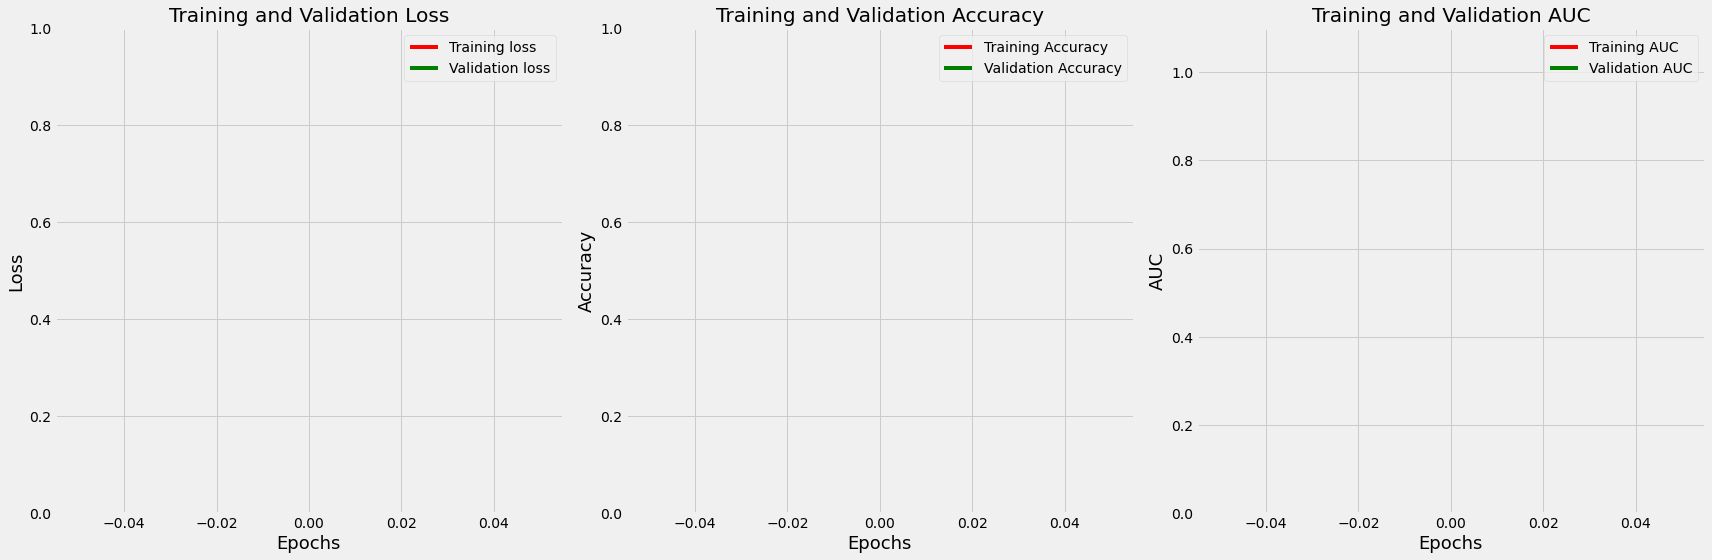

In [52]:
def plot_auc_acc_loss(history, epochs):
    tacc = history.history['accuracy']
    tloss = history.history['loss']
    tauc = history.history['auc']

    vacc = history.history['val_accuracy']
    vloss = history.history['val_loss']
    vauc = history.history['val_auc']

    Epochs = [i for i in range(epochs)]

    plt.style.use('fivethirtyeight')
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(24, 8))
    axes[0].plot(tloss, 'r', label='Training loss')
    axes[0].plot(vloss, 'g', label='Validation loss')
    axes[0].set_ylim(0, 1)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs', fontsize=18)
    axes[0].set_ylabel('Loss', fontsize=18)
    axes[0].legend()

    axes[1].plot(tacc, 'r', label='Training Accuracy')
    axes[1].plot(vacc, 'g', label='Validation Accuracy')
    axes[1].set_ylim(0, 1)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs', fontsize=18)
    axes[1].set_ylabel('Accuracy', fontsize=18)
    axes[1].legend()

    axes[2].plot(tauc, 'r', label='Training AUC')
    axes[2].plot(vauc, 'g', label='Validation AUC')
    axes[2].set_ylim(0, 1.1)
    axes[2].set_title('Training and Validation AUC')
    axes[2].set_xlabel('Epochs', fontsize=18)
    axes[2].set_ylabel('AUC', fontsize=18)
    axes[2].legend()

    plt.tight_layout()
    plt.show()

    return Epochs

Epochs = plot_auc_acc_loss(history, epochs=1)

Confusion matrix

38/38 [==============================] - 48s 1s/step
there were 20 errors in 298 tests for an accuracy of  93.29%


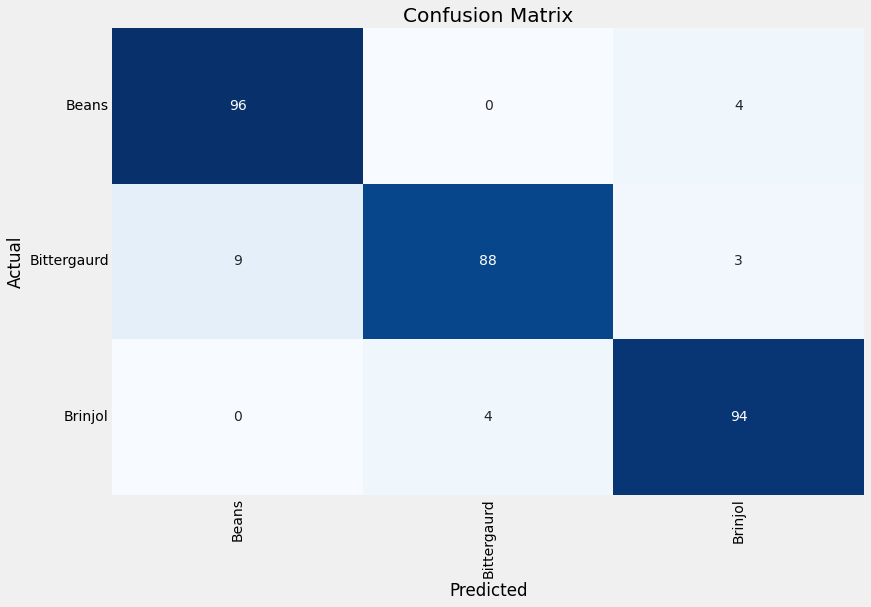



Classification Report:
----------------------
               precision    recall  f1-score   support

       Beans     0.9143    0.9600    0.9366       100
 Bittergaurd     0.9565    0.8800    0.9167       100
     Brinjol     0.9307    0.9592    0.9447        98

    accuracy                         0.9329       298
   macro avg     0.9338    0.9331    0.9327       298
weighted avg     0.9339    0.9329    0.9326       298



In [49]:
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def predictor(test_ds):
    y_pred, error_list, error_pred_list = [], [], []
    y_true = test_ds.labels
    classes = list(test_ds.class_indices.keys())
    class_count = len(classes)
    errors = 0
    pdct = model.predict(test_ds)
    preds = tf.argmax(pdct, axis=1)
    tests = len(preds)
    for i in range(tests):
        pred_index = preds[i]
        true_index = test_ds.labels[i]
        if pred_index != true_index:
            errors += 1
            file = test_ds.filenames[i]
            error_list.append(file)
            error_classes = classes[pred_index]
            error_pred_list.append(error_classes)
        y_pred.append(pred_index)

    acc = (1 - errors / tests) * 100
    msg = f'there were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}%'
    print(msg)
    ypred = np.array(y_pred)
    ytrue = np.array(y_true)
    f1score = f1_score(ytrue, ypred, average='weighted') * 100

    if class_count <= 30:
        cm = confusion_matrix(y_true, y_pred)

        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
        plt.xticks(np.arange(class_count) + .5, classes, rotation=90)
        plt.yticks(np.arange(class_count) + .5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()

    clr = classification_report(y_true, y_pred, target_names=classes, digits=4)
    print("\n\nClassification Report:\n----------------------\n", clr)

    return errors, tests, error_list, error_pred_list, f1score

errors, tests, error_list, error_pred_list, f1score = predictor(test_ds)